
Improved Two-Level Prototypical Networks with Patch Explanation on CUB-200-2011

Focuses on reducing overfitting without augmentation using:
- Differential Learning Rates
- Layer Freezing
- Dropout
- Label Smoothing
- Gradient Clipping
- Increased Episodes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm # Use standard tqdm if not in notebook
import math
import os
from PIL import Image
import copy # For deep copying models/optimizers state
import json

In [20]:
# -------------------------------------
# --- Configuration ---
# -------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Dataset params
DATA_DIR = '/content/drive/MyDrive/CUB_200_2011' #<---- CHECK YOUR PATH
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
IMAGE_SIZE = 224
# N_CLASSES_SUBSET # Will be determined dynamically now

# Episode params
N_WAY = 5          # Increase N_WAY for more challenging tasks if classes available
K_SHOT = 5
N_QUERY = 10
# Increase significantly for meta-learning to see diverse tasks
N_TRAIN_EPISODES = 3000
N_TEST_EPISODES = 600

# --- NEW: Fixed Meta-Split Configuration ---
# Set USE_FIXED_SPLIT to True if you specifically want the 15/5 split
# when exactly 20 classes are detected.
USE_FIXED_SPLIT = True
N_META_TRAIN_CLASSES_TARGET = 15
N_META_TEST_CLASSES_TARGET = 5
# The ratio below will be used as a fallback if USE_FIXED_SPLIT is False
# or if the number of detected classes is not exactly 20.
FALLBACK_META_TRAIN_RATIO = 0.7 # Keep the original ratio as fallback


# Model params
EMBEDDING_DIM = 256 # Feature embedding dimension
PRETRAINED = True
FREEZE_UNTIL_LAYER = "layer3" # Options: None, "stem", "layer1", "layer2", "layer3"

# Training params (NEW: Differential LR & Stronger Regularization)
LR_BACKBONE = 1e-5      # Lower LR for frozen/finetuned backbone
LR_HEAD = 1e-4          # Higher LR for the new embedding layer
WEIGHT_DECAY = 5e-4      # Increased weight decay
LABEL_SMOOTHING = 0.1    # Use label smoothing
GRADIENT_CLIP_NORM = 1.0 # Use gradient clipping

# Visualization Params
PATCH_SIZE_VIS = 28 # Approximate size of patch to draw

import json
import random
import pandas as pd
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from tqdm.auto import tqdm # Use auto tqdm

# --- Make sure these are defined (or passed as arguments) ---
# IMAGE_SIZE = 224 # Defined in config
# K_SHOT = 5       # Defined in config
# N_QUERY = 10     # Defined in config
# N_WAY = 5        # Defined in config (can be adjusted later)
# IMAGES_DIR = '...' # Defined in config

def parse_cub_metadata(data_dir):
    """Reads CUB metadata files into pandas DataFrames."""
    images_path = os.path.join(data_dir, 'images.txt')
    labels_path = os.path.join(data_dir, 'image_class_labels.txt')
    split_path = os.path.join(data_dir, 'train_test_split.txt')
    bbox_path = os.path.join(data_dir, 'bounding_boxes.txt')
    classes_path = os.path.join(data_dir, 'classes.txt')

    required_files = [images_path, labels_path, split_path, bbox_path, classes_path]
    for f_path in required_files:
        if not os.path.exists(f_path):
            raise FileNotFoundError(f"Metadata file not found: {f_path}.")

    df_images = pd.read_csv(images_path, sep=' ', names=['img_id', 'filepath'])
    df_labels = pd.read_csv(labels_path, sep=' ', names=['img_id', 'class_id'])
    df_split = pd.read_csv(split_path, sep=' ', names=['img_id', 'is_training'])
    df_bboxes = pd.read_csv(bbox_path, sep=' ', names=['img_id', 'x', 'y', 'width', 'height'])
    df_classes = pd.read_csv(classes_path, sep=' ', names=['class_id', 'class_name'])

    df_labels['class_id'] = df_labels['class_id'] - 1 # 0-based
    df = df_images.merge(df_labels, on='img_id')
    df = df.merge(df_split, on='img_id')
    df = df.merge(df_bboxes, on='img_id')
    df['full_path'] = df['filepath'].apply(lambda x: os.path.join(IMAGES_DIR, x)) # Use global IMAGES_DIR
    class_id_to_name = df_classes.set_index('class_id')['class_name'].to_dict()
    class_id_to_name = {(k - 1): v for k, v in class_id_to_name.items()} # Adjust keys to 0-based
    print(f"Parsed metadata for {len(df)} total image entries across {df['class_id'].nunique()} original classes.")
    return df, class_id_to_name

class CubDataset(Dataset):
    """Custom Dataset for CUB-200-2011 with cropping."""
    def __init__(self, df_subset, transform=None):
        self.df = df_subset
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_info = self.df.iloc[idx]
        img_path = img_info['full_path']
        label = img_info['subset_class_id'] # Use 0-based subset ID
        bbox = (img_info['x'], img_info['y'], img_info['width'], img_info['height'])

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Warning: File not found {img_path}. Skipping.")
            return None, -1 # Return identifiable invalid data
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, -1 # Return identifiable invalid data

        x, y, w, h = bbox
        left, upper = int(np.floor(x)), int(np.floor(y))
        right, lower = int(np.ceil(x + w)), int(np.ceil(y + h))
        img_width, img_height = image.size
        left, upper = max(0, left), max(0, upper)
        right, lower = min(img_width, right), min(img_height, lower)

        # Handle potential invalid bounding boxes (width/height=0 after clipping)
        if right <= left or lower <= upper:
            # Option 1: Use the full image if crop is invalid
            # image = image
            # Option 2: Skip this image (might reduce class sample size)
            # print(f"Warning: Invalid bbox resulting in zero-area crop for {img_path}. Skipping.")
            # return None, -1
            # Option 3: Use a default crop or center crop (less ideal for CUB)
            # Let's stick with using the full image if crop fails
            pass # Keep original image if crop dims invalid
        else:
             image = image.crop((left, upper, right, lower))


        if self.transform:
            image = self.transform(image)

        # Ensure image is valid tensor before returning
        if not isinstance(image, torch.Tensor):
             print(f"Warning: Transform did not produce a tensor for {img_path}. Skipping.")
             return None, -1

        return image, label


def prepare_cub_data_splits(data_dir,
                              use_fixed_split=USE_FIXED_SPLIT, # Use global config
                              n_meta_train_target=N_META_TRAIN_CLASSES_TARGET, # Use global config
                              n_meta_test_target=N_META_TEST_CLASSES_TARGET, # Use global config
                              fallback_ratio=FALLBACK_META_TRAIN_RATIO, # Use global config
                              split_save_path="cub_meta_split.json",
                              force_resplit=False):
    """
    Loads CUB data, detects available classes, prepares meta-splits
    (using fixed numbers if possible and requested, otherwise ratio-based fallback),
    and creates data lists for samplers.

    Args:
        data_dir (str): Path to the CUB dataset root.
        use_fixed_split (bool): Try to use fixed target numbers if total classes match.
        n_meta_train_target (int): Target number of meta-train classes for fixed split.
        n_meta_test_target (int): Target number of meta-test classes for fixed split.
        fallback_ratio (float): Ratio for meta-training if fixed split not used.
        split_save_path (str): Path to save/load the class split indices file.
        force_resplit (bool): If True, ignore existing split file and create a new one.

    Returns:
        tuple: (meta_train_data, meta_test_data, n_meta_train_classes, n_meta_test_classes) or (None, None, 0, 0) on failure.
    """
    images_dir_local = os.path.join(data_dir, 'images')
    if not os.path.isdir(images_dir_local):
         raise FileNotFoundError(f"Images directory not found: {images_dir_local}")

    df_all, class_id_to_name_map = parse_cub_metadata(data_dir)

    # --- Detect Available Classes ---
    available_folders = [d for d in os.listdir(images_dir_local) if os.path.isdir(os.path.join(images_dir_local, d))]
    available_original_class_ids = []
    for folder_name in available_folders:
        try:
            # Assumes folder names like "001.Black_footed_Albatross"
            class_num_str = folder_name.split('.')[0]
            original_id_one_based = int(class_num_str)
            available_original_class_ids.append(original_id_one_based - 1) # Store 0-based IDs
        except ValueError:
            print(f"Warning: Could not parse class ID from folder name: {folder_name}. Skipping.")
            continue
        except Exception as e:
            print(f"Warning: Error processing folder name {folder_name}: {e}. Skipping.")
            continue

    if not available_original_class_ids:
        raise ValueError("No valid class folders found or parsed in images directory.")

    # Filter df_all to only include images from detected classes BEFORE getting unique IDs
    df_all_detected = df_all[df_all['class_id'].isin(available_original_class_ids)].copy()
    if df_all_detected.empty:
         raise ValueError("No images found corresponding to the detected class folders.")

    # Get the unique, sorted list of class IDs *that actually have images*
    final_available_class_ids = sorted(df_all_detected['class_id'].unique().tolist())
    N_CLASSES_TOTAL_DETECTED = len(final_available_class_ids)


    print(f"\nDetected {N_CLASSES_TOTAL_DETECTED} classes with available images.")
    print("Sample Detected Classes:")
    for i, cid in enumerate(final_available_class_ids[:min(5, N_CLASSES_TOTAL_DETECTED)]):
         print(f"  ID {cid}: {class_id_to_name_map.get(cid, 'Unknown Name')}")
    if N_CLASSES_TOTAL_DETECTED > 5: print("  ...")


    # --- Load or Create Meta-Split ---
    meta_train_subset_indices = None
    meta_test_subset_indices = None
    target_total_classes = n_meta_train_target + n_meta_test_target

    if os.path.exists(split_save_path) and not force_resplit:
        print(f"Attempting to load existing class split from: {split_save_path}")
        try:
            with open(split_save_path, 'r') as f:
                split_data = json.load(f)
            # Basic validation
            if ('meta_train_indices' in split_data and 'meta_test_indices' in split_data and
                isinstance(split_data['meta_train_indices'], list) and
                isinstance(split_data['meta_test_indices'], list)):

                loaded_train_indices = split_data['meta_train_indices']
                loaded_test_indices = split_data['meta_test_indices']

                # Map loaded indices (which are subset indices) back to original class IDs
                # This requires knowing how the split was originally created, which is tricky.
                # Let's instead check if the *number* of classes in the split matches expectations.
                # This isn't foolproof but better than nothing.
                expected_num_train = n_meta_train_target if use_fixed_split and N_CLASSES_TOTAL_DETECTED == target_total_classes else int(N_CLASSES_TOTAL_DETECTED * fallback_ratio)
                expected_num_test = n_meta_test_target if use_fixed_split and N_CLASSES_TOTAL_DETECTED == target_total_classes else N_CLASSES_TOTAL_DETECTED - expected_num_train

                # Check for overlap
                if set(loaded_train_indices).intersection(set(loaded_test_indices)):
                     print("Warning: Loaded split has overlapping train/test indices. Will create new split.")
                # Check if counts broadly match expectation (loosely)
                elif len(loaded_train_indices) + len(loaded_test_indices) != N_CLASSES_TOTAL_DETECTED:
                     print(f"Warning: Loaded split has {len(loaded_train_indices)+len(loaded_test_indices)} total indices, but {N_CLASSES_TOTAL_DETECTED} classes detected now. Will create new split.")
                else:
                    # If counts match detected total and no overlap, assume it's valid for now
                    # The actual classes inside might differ run-to-run if detection changes slightly,
                    # but using the saved indices maintains consistency *for those indices*.
                    meta_train_subset_indices = loaded_train_indices
                    meta_test_subset_indices = loaded_test_indices
                    print("Successfully loaded existing split. Using saved class indices.")
            else:
                print(f"Warning: Invalid format in {split_save_path}. Will create new split.")
        except Exception as e:
            print(f"Error loading split file {split_save_path}: {e}. Will create new split.")

    # If split wasn't loaded, create and save a new one
    if meta_train_subset_indices is None or meta_test_subset_indices is None:
        print("Creating new meta-train/test class split...")
        split_comment = ""

        # --- CORE CHANGE: Decide on split numbers ---
        if use_fixed_split and N_CLASSES_TOTAL_DETECTED == target_total_classes:
            n_meta_train_actual = n_meta_train_target
            n_meta_test_actual = n_meta_test_target
            print(f"Using fixed split: {n_meta_train_actual} meta-train / {n_meta_test_actual} meta-test classes.")
            split_comment = f'Fixed {n_meta_train_actual}/{n_meta_test_actual} split of {N_CLASSES_TOTAL_DETECTED} detected classes.'

        else:
            if use_fixed_split: # Only print warning if fixed was intended but not possible
                 print(f"WARNING: Cannot use fixed {n_meta_train_target}/{n_meta_test_target} split because {N_CLASSES_TOTAL_DETECTED} classes were detected (expected {target_total_classes}).")
            print(f"Using fallback ratio-based split ({fallback_ratio*100:.1f}% train).")
            n_meta_train_actual = int(N_CLASSES_TOTAL_DETECTED * fallback_ratio)
            n_meta_test_actual = N_CLASSES_TOTAL_DETECTED - n_meta_train_actual
            split_comment = f'Ratio-based ({fallback_ratio*100:.1f}%) split of {N_CLASSES_TOTAL_DETECTED} detected classes.'

        # --- Ensure split is possible ---
        if n_meta_train_actual <= 0 or n_meta_test_actual <= 0:
            raise ValueError(f"Cannot split {N_CLASSES_TOTAL_DETECTED} classes into train/test ({n_meta_train_actual}/{n_meta_test_actual}). Need more classes or adjust split criteria.")
        # Ensure N_WAY is feasible even for the smaller split part
        global N_WAY # Allow modification
        if N_WAY > n_meta_train_actual or N_WAY > n_meta_test_actual:
             min_possible_way = min(n_meta_train_actual, n_meta_test_actual)
             if min_possible_way > 0:
                 print(f"WARNING: N_WAY ({N_WAY}) is too large for the planned split ({n_meta_train_actual} train, {n_meta_test_actual} test classes). Reducing N_WAY to {min_possible_way}.")
                 N_WAY = min_possible_way
             else:
                  raise ValueError(f"Cannot proceed: Split resulted in {n_meta_train_actual} train / {n_meta_test_actual} test classes, which is too few for N_WAY={N_WAY}.")


        # --- Perform the split ---
        # We split the *original class IDs* that were detected
        current_indices = list(range(N_CLASSES_TOTAL_DETECTED)) # Indices corresponding to final_available_class_ids
        random.shuffle(current_indices)

        meta_train_subset_indices = sorted(current_indices[:n_meta_train_actual])
        meta_test_subset_indices = sorted(current_indices[n_meta_train_actual:])

        # --- Save the new split (using the subset indices 0..N-1) ---
        try:
            split_data_to_save = {
                'meta_train_indices': meta_train_subset_indices, # Save indices 0..N-1
                'meta_test_indices': meta_test_subset_indices,   # Save indices 0..N-1
                'comment': split_comment,
                'original_class_ids_used': final_available_class_ids # Store which original IDs these indices correspond to
            }
            with open(split_save_path, 'w') as f:
                json.dump(split_data_to_save, f, indent=4)
            print(f"Saved new class split to: {split_save_path}")
        except Exception as e:
            print(f"Error saving new split file {split_save_path}: {e}")


    # Now we have the definitive meta_train/test_subset_indices (relative to final_available_class_ids)
    n_meta_train_final = len(meta_train_subset_indices)
    n_meta_test_final = len(meta_test_subset_indices)
    print(f"Using finalized split: {n_meta_train_final} meta-train classes, {n_meta_test_final} meta-test classes.")

    # --- Map subset indices (0..N-1) back to original CUB class IDs ---
    meta_train_original_class_ids = [final_available_class_ids[i] for i in meta_train_subset_indices]
    meta_test_original_class_ids = [final_available_class_ids[i] for i in meta_test_subset_indices]

    # --- Create the final DataFrame subsets based on ORIGINAL Class IDs ---
    df_meta_train = df_all_detected[df_all_detected['class_id'].isin(meta_train_original_class_ids)].copy()
    df_meta_test = df_all_detected[df_all_detected['class_id'].isin(meta_test_original_class_ids)].copy()

    # --- Create new SUBSET class IDs (0 to num_train-1) and (0 to num_test-1) for each split ---
    # This is important for the EpisodeSampler which expects contiguous labels 0 to N_WAY-1
    train_map = {orig_id: new_id for new_id, orig_id in enumerate(sorted(meta_train_original_class_ids))}
    test_map = {orig_id: new_id for new_id, orig_id in enumerate(sorted(meta_test_original_class_ids))}

    df_meta_train['subset_class_id'] = df_meta_train['class_id'].map(train_map)
    df_meta_test['subset_class_id'] = df_meta_test['class_id'].map(test_map)

    # --- Define Transforms ---
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        normalize,
    ])

    # Separate CUB's train/test split *within* our meta-train/test class splits
    df_meta_train_cub_train = df_meta_train[df_meta_train['is_training'] == 1]
    df_meta_test_cub_test = df_meta_test[df_meta_test['is_training'] == 0]

    # --- Helper to load images for meta-datasets ---
    def load_data_for_split(target_original_ids, df_source, subset_map, split_name):
        data = []
        # Use the subset_map to iterate through 0..N-1 required by sampler
        pbar = tqdm(range(len(target_original_ids)), desc=f"Processing Meta-{split_name} Classes")
        original_ids_in_order = sorted(target_original_ids) # Ensure consistent order

        for subset_class_id in pbar: # Iterate 0..N-1
            original_class_id = original_ids_in_order[subset_class_id]
            pbar.set_postfix({"Orig ClassID": original_class_id})

            # Filter the source DataFrame for this original class ID
            class_df = df_source[df_source['class_id'] == original_class_id]

            if not class_df.empty:
                 # Pass the DataFrame already filtered for this class, ensuring correct 'subset_class_id'
                temp_dataset = CubDataset(class_df, transform=transform)
                # Collect images, ensuring they are not None
                images = []
                labels = []
                for i in range(len(temp_dataset)):
                    img, lbl = temp_dataset[i]
                    if img is not None:
                        # Ensure the label is the subset_class_id (0..N-1)
                        assert lbl == subset_class_id, f"Label mismatch! Expected {subset_class_id}, got {lbl} for original ID {original_class_id}"
                        images.append(img)
                        labels.append(lbl) # Store the correct subset label

                if images:
                    data.append((subset_class_id, images)) # Store with the SUBSET class ID

        # Validation checks (using potentially reduced N_WAY)
        min_samples_needed = K_SHOT + N_QUERY
        valid_classes_count = 0
        problematic_classes = []
        for subset_id, imgs in data:
             if len(imgs) >= min_samples_needed:
                 valid_classes_count += 1
             else:
                 # Find original ID for reporting
                 orig_id_for_report = original_ids_in_order[subset_id]
                 problematic_classes.append(f"ID {orig_id_for_report} (subset {subset_id}): {len(imgs)} samples")

        if problematic_classes:
             print(f"\n*** WARNING ({split_name}): {len(problematic_classes)}/{len(data)} classes have < {min_samples_needed} samples (need replacement). Examples:")
             for problem in problematic_classes[:5]: print(f"  - {problem}")
             if len(problematic_classes) > 5: print("  ...")

        if valid_classes_count < N_WAY: # Use potentially reduced N_WAY
             print(f"*** CRITICAL WARNING ({split_name}): Only {valid_classes_count} classes have enough samples ({min_samples_needed} required). N_WAY ({N_WAY}) might be impossible without replacement during sampling.")

        # Sort data by subset_class_id to ensure consistency
        data.sort(key=lambda x: x[0])
        return data

    print("\nBuilding meta-train data (using CUB train split images)...")
    # Use the CUB training images for meta-training classes
    meta_train_data = load_data_for_split(meta_train_original_class_ids, df_meta_train_cub_train, train_map, "Train")

    print("\nBuilding meta-test data (using CUB test split images)...")
    # Use the CUB testing images for meta-testing classes
    meta_test_data = load_data_for_split(meta_test_original_class_ids, df_meta_test_cub_test, test_map, "Test")

    print(f"\nFinal classes available for meta-train sampler: {len(meta_train_data)}")
    print(f"Final classes available for meta-test sampler: {len(meta_test_data)}")

    if not meta_train_data or not meta_test_data:
        print("\n*** ERROR: Empty meta_train_data or meta_test_data after processing. Check data integrity/paths/filtering. ***")
        return None, None, 0, 0

    # Return the data lists AND the actual number of classes in each split
    return meta_train_data, meta_test_data, n_meta_train_final, n_meta_test_final

# --- Episode Sampler (Largely Unchanged, but relies on correct input format) ---
class EpisodeSampler:
    """Samples episodes for N-way K-shot learning."""
    def __init__(self, meta_data, n_way, k_shot, n_query):
        self.meta_data = meta_data # Expects list of [(subset_class_id_0, [img_tensors]), (subset_class_id_1, [img_tensors]), ...]
        if not meta_data:
            raise ValueError("Meta data for sampler cannot be empty or None")

        self.num_classes = len(meta_data) # Number of classes available in this split

        # Validate n_way against the *actual* number of classes provided
        if n_way <= 0 :
             raise ValueError(f"N_WAY ({n_way}) must be positive.")
        if n_way > self.num_classes:
            raise ValueError(f"N_WAY ({n_way}) cannot be greater than the number of classes available in this meta-split ({self.num_classes}).")

        self.n_way = n_way
        self.k_shot = k_shot
        self.n_query = n_query
        self.min_samples_per_class = k_shot + n_query

        # Pre-check if sampling is even possible without replacement for all classes
        classes_with_enough_samples = 0
        for subset_class_id, images in self.meta_data:
            if len(images) >= self.min_samples_per_class:
                classes_with_enough_samples += 1
        if classes_with_enough_samples < self.n_way:
             print(f"Sampler Warning: Only {classes_with_enough_samples} classes have the required {self.min_samples_per_class} samples. N_WAY is {self.n_way}. Sampling will require replacement for some classes.")


    def sample(self):
        support_imgs, support_lbls, query_imgs, query_lbls = [], [], [], []

        # Sample N_WAY class *indices* from the available classes in meta_data
        try:
            # These are indices into the self.meta_data list (0 to self.num_classes - 1)
            sampled_meta_indices = random.sample(range(self.num_classes), self.n_way)
        except ValueError as e:
            # This should have been caught by the __init__ check, but double-check
            print(f"Error sampling class indices: Need {self.n_way}-way, but only {self.num_classes} classes available.")
            raise e

        # Iterate through the *sampled* classes using their index in meta_data
        for local_label, meta_idx in enumerate(sampled_meta_indices):
            # Retrieve the actual subset_class_id and images for this sampled class
            # The subset_class_id stored in meta_data[meta_idx][0] should match meta_idx if data was sorted, but retrieve image list anyway
            _, images = self.meta_data[meta_idx]
            n_available = len(images)
            n_needed = self.k_shot + self.n_query

            # Decide whether to sample with replacement for this specific class
            use_replacement = n_available < n_needed
            if use_replacement:
                 # print(f"Debug: Using replacement for class (meta_idx {meta_idx}), needed {n_needed}, available {n_available}")
                 pass # Can add print for debugging

            # Sample indices *from the image list of this class*
            try:
                indices = random.choices(range(n_available), k=n_needed) if use_replacement else random.sample(range(n_available), n_needed)
            except ValueError as e:
                 print(f"Error sampling images for class (meta_idx {meta_idx}): Needed {n_needed}, available {n_available}, Replacement={use_replacement}")
                 # This likely means n_available is 0, which should ideally be filtered earlier
                 # For robustness, maybe skip this class in the episode? Or raise error? Let's raise.
                 raise ValueError(f"Cannot sample {n_needed} images from class (meta_idx {meta_idx}) with only {n_available} available.") from e


            # Assign images to support/query sets using the sampled image indices
            support_imgs.extend([images[i] for i in indices[:self.k_shot]])
            support_lbls.extend([local_label] * self.k_shot) # Use the local label (0 to N_WAY-1)
            query_imgs.extend([images[i] for i in indices[self.k_shot:]])
            query_lbls.extend([local_label] * self.n_query)   # Use the local label (0 to N_WAY-1)

        # --- Batch and Shuffle ---
        # Check if any tensors were actually collected
        if not support_imgs or not query_imgs:
             # This could happen if all sampled classes had errors or no images
             raise RuntimeError("Failed to collect any support or query images for the episode.")

        try:
            support_imgs = torch.stack(support_imgs)
            support_lbls = torch.LongTensor(support_lbls)
            query_imgs = torch.stack(query_imgs)
            query_lbls = torch.LongTensor(query_lbls)
        except Exception as e:
            print(f"Error stacking tensors. Support length: {len(support_imgs)}, Query length: {len(query_imgs)}")
            # Optionally print shapes of individual tensors if they fail to stack
            # for i, img in enumerate(support_imgs): print(f"Support img {i} shape: {img.shape}")
            # for i, img in enumerate(query_imgs): print(f"Query img {i} shape: {img.shape}")
            raise e


        # Shuffle query set only (support set order doesn't usually matter for prototypes)
        perm = torch.randperm(len(query_lbls))
        query_imgs, query_lbls = query_imgs[perm], query_lbls[perm]

        return support_imgs, support_lbls, query_imgs, query_lbls

Using device: cuda


In [21]:
# -------------------------------------
# --- Model Architecture (Improved Encoder) ---
# -------------------------------------
class ResNetEncoderWithDropout(nn.Module):
    """
    Encoder based on pretrained ResNet18 with layer freezing and dropout.
    Provides access to both convolutional features and final embeddings.
    """
    def __init__(self, embedding_dim=EMBEDDING_DIM, pretrained=True, freeze_until=None, dropout_rate=0.5):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)

        # Backbone Feature Extraction Layers
        self.stem = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # Feature extractor combines these layers
        self.feature_extractor = nn.Sequential(
            self.stem, self.layer1, self.layer2, self.layer3, self.layer4
        )

        # Freeze layers based on configuration
        if freeze_until:
            self._freeze_layers(freeze_until)

        # Embedding Head
        resnet_out_dim = resnet.fc.in_features # 512 for ResNet18
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout_rate) # Add dropout before final layer
        self.embedding_layer = nn.Linear(resnet_out_dim, embedding_dim)

        self.embedding_head = nn.Sequential(
            self.global_pool,
            self.flatten,
            self.dropout,
            self.embedding_layer
        )

        # Calculate total stride (typically 32 for ResNet18)
        self.total_stride = 32 # Assuming standard ResNet strides

    def _freeze_layers(self, freeze_until):
        print(f"Freezing ResNet layers up to and including: {freeze_until}")
        target_modules = []
        if freeze_until == "stem":
            target_modules.append(self.stem)
        elif freeze_until == "layer1":
            target_modules.extend([self.stem, self.layer1])
        elif freeze_until == "layer2":
            target_modules.extend([self.stem, self.layer1, self.layer2])
        elif freeze_until == "layer3":
            target_modules.extend([self.stem, self.layer1, self.layer2, self.layer3])
        # Note: We don't explicitly handle layer4 here for freezing based on common practice.
        # layer4 and embedding_head should generally remain trainable for adaptation.

        for module in target_modules:
            for param in module.parameters():
                param.requires_grad = False

        # --- Verification ---
        print("Trainable status check (at end of _freeze_layers):")
        # Check only modules DEFINED before or during freezing
        defined_modules_to_check = [
            ('stem', self.stem),
            ('layer1', self.layer1),
            ('layer2', self.layer2),
            ('layer3', self.layer3),
            ('layer4', self.layer4) # Layer 4 is defined, just maybe not frozen
        ]
        for name, module in defined_modules_to_check:
             try: # Use try-except in case a layer is unexpectedly missing
                 is_trainable = any(p.requires_grad for p in module.parameters())
                 print(f"  {name}: {'Trainable' if is_trainable else 'Frozen'}")
             except AttributeError:
                 print(f"  {name}: Not found (AttributeError during check)")
        # We will check embedding_head status later, after it's fully initialized
        print("(Embedding head status check deferred)")


    def forward(self, x):
        conv_features = self.feature_extractor(x) # e.g., [B, 512, H/32, W/32]
        embedding = self.embedding_head(conv_features) # -> [B, embedding_dim]
        return conv_features, embedding

    def get_trainable_parameters(self):
        """ Helper to get parameters for differential learning rates """
        backbone_params = []
        head_params = []

        # Explicitly identify parameters of the embedding head layers by their attribute names
        head_param_names = set()
        for param_name, _ in self.embedding_layer.named_parameters():
            head_param_names.add(f"embedding_layer.{param_name}")
        # Add parameters from other head components if they have any (dropout usually doesn't)
        # e.g., if you added another Linear or Conv2d layer to the head

        print(f"DEBUG: Identified head parameter base names: {head_param_names}")

        for name, param in self.named_parameters():
            # Check if parameter requires gradient (might be frozen)
            if not param.requires_grad:
                continue

            is_head_param = False
            # Check if the parameter name corresponds to one of the layers in the head
            # Primarily check the final linear layer which always has trainable parameters
            if name.startswith("embedding_layer."): # Direct check is simplest
                is_head_param = True
            # Optional: add checks for other head layers if they have parameters
            # elif name.startswith("some_other_head_layer."):
            #    is_head_param = True


            if is_head_param:
                 print(f"DEBUG: Assigning '{name}' to HEAD parameters.")
                 head_params.append(param)
            else:
                 # Assign remaining trainable params (from unfrozen backbone layers like layer4) to backbone group
                 print(f"DEBUG: Assigning '{name}' to BACKBONE parameters.")
                 backbone_params.append(param)

        print(f"Differential LR setup: {len(backbone_params)} backbone params, {len(head_params)} head params.")
        if not head_params:
             print("Warning: No parameters identified for the embedding head!")
        # It's okay if backbone_params is small if many layers are frozen
        # if not backbone_params:
        #     print("Warning: No parameters identified for the backbone (is everything frozen?)")

        return backbone_params, head_params


# --- PrototypicalNet (Minor Adjustments for Stability/Clarity) ---
class ExplainablePrototypicalNet(nn.Module):
    """
    Main model using the improved ResNet encoder with dropout/freezing.
    Implements Level 1 Classification and Level 2 Patch Explanation.
    """
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def _calculate_prototypes(self, support_embeddings, support_labels, n_way):
        # Add small epsilon for numerical stability if needed, though mean is usually fine
        prototypes = torch.zeros(n_way, support_embeddings.size(1), device=support_embeddings.device)
        for c in range(n_way):
            class_embeddings = support_embeddings[support_labels == c]
            if class_embeddings.size(0) > 0:
                prototypes[c] = class_embeddings.mean(dim=0)
            # Else: prototype remains zero, distance will be high (correct behaviour)
        return prototypes

    def _compute_distances(self, query_embeddings, prototypes):
         # Calculate squared Euclidean distance efficiently
        return torch.cdist(query_embeddings, prototypes)**2

    def level1_classify(self, support_embeddings, support_labels, query_embeddings, n_way):
        prototypes = self._calculate_prototypes(support_embeddings, support_labels, n_way)
        # distances shape: [n_query, n_way]
        distances = self._compute_distances(query_embeddings, prototypes)
        logits = -distances # Lower distance = higher logit
        return logits

    def level2_explain_per_support_image_topk(self, query_conv_features, support_conv_features_list,predicted_class_support_indices, top_k=3):
        explanation_results_per_support = {}
        if query_conv_features.size(0) != 1: return explanation_results_per_support
        if not predicted_class_support_indices: return explanation_results_per_support

        B, D, H, W = query_conv_features.shape
        N_PATCHES_Q = H * W
        if N_PATCHES_Q <= 0: return explanation_results_per_support

        query_patches = query_conv_features.permute(0, 2, 3, 1).reshape(N_PATCHES_Q, D)
        query_patches_clean = torch.nan_to_num(query_patches, nan=0.0) # Basic cleaning

        scale_factor = math.sqrt(D) if D > 0 else 1.0

        for support_global_idx in predicted_class_support_indices:
            support_feat_single = support_conv_features_list[support_global_idx].unsqueeze(0) # [1, D, H, W]
            _, _, Hs, Ws = support_feat_single.shape
            N_PATCHES_S = Hs * Ws
            if N_PATCHES_S <= 0: continue # Skip invalid support feature map

            support_patches_single_img = support_feat_single.permute(0, 2, 3, 1).reshape(N_PATCHES_S, D)
            support_patches_single_clean = torch.nan_to_num(support_patches_single_img, nan=0.0)

            top_k_results_for_support = []
            try:
                # Calculate pairwise similarity (using attention scores here)
                attn_scores = torch.matmul(query_patches_clean, support_patches_single_clean.t()) / scale_factor
                # Shape: [N_PATCHES_Q, N_PATCHES_S]

                if torch.isnan(attn_scores).any() or torch.isinf(attn_scores).any():
                     print(f"Warning: NaN/Inf in scores for support img {support_global_idx}. Clamping.")
                     attn_scores = torch.nan_to_num(attn_scores, nan=-1e9) # Assign low score

                # Get top-k scores and their flat indices
                num_elements = N_PATCHES_Q * N_PATCHES_S
                actual_top_k = min(top_k, num_elements) # Ensure top_k doesn't exceed total elements
                if actual_top_k <= 0: continue # Skip if no patches

                top_k_scores, top_k_flat_indices = torch.topk(attn_scores.flatten(), k=actual_top_k, dim=0)

                # Convert flat indices back to (query_idx, support_idx)
                for i in range(actual_top_k):
                    flat_idx = top_k_flat_indices[i].item()
                    q_idx = flat_idx // N_PATCHES_S
                    s_idx = flat_idx % N_PATCHES_S
                    score = top_k_scores[i].item()
                    top_k_results_for_support.append((q_idx, s_idx, score))

                explanation_results_per_support[support_global_idx] = top_k_results_for_support

            except Exception as e:
                 print(f"Error during Top-K explanation for support img {support_global_idx}: {e}")
                 continue # Skip this support image on error

        return explanation_results_per_support

    def forward(self, support_images, support_labels, query_images, n_way):
        n_support = support_images.size(0)
        n_query = query_images.size(0)
        all_images = torch.cat([support_images, query_images], dim=0)

        # Get features and embeddings
        # Use try-except to catch potential errors during forward pass (e.g. OOM)
        try:
            all_conv_features, all_embeddings = self.encoder(all_images)
        except Exception as e:
            print(f"Error during encoder forward pass: {e}")
             # Return dummy values or re-raise, depends on how you want to handle upstream
            dummy_logits = torch.zeros(n_query, n_way).to(all_images.device)
            dummy_q_conv = torch.zeros(n_query, EMBEDDING_DIM, 1, 1).to(all_images.device) # Adjust D,H,W if needed
            dummy_s_conv = torch.zeros(n_support, EMBEDDING_DIM, 1, 1).to(all_images.device)
            return dummy_logits, dummy_q_conv, dummy_s_conv

        # Split back into support and query
        support_embeddings = all_embeddings[:n_support]
        query_embeddings = all_embeddings[n_support:]
        support_conv_features = all_conv_features[:n_support]
        query_conv_features = all_conv_features[n_support:]

        # Level 1 classification
        logits = self.level1_classify(support_embeddings, support_labels, query_embeddings, n_way)

        return logits, query_conv_features, support_conv_features

In [22]:
# -------------------------------------
# --- Training & Evaluation (Improved) ---
# -------------------------------------

# Use CrossEntropyLoss with Label Smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

def train_step(model, optimizer, loss_fn, support_images, support_labels, query_images, query_labels, n_way, gradient_clip_norm):
    model.train()
    optimizer.zero_grad()

    support_images = support_images.to(DEVICE)
    support_labels = support_labels.to(DEVICE)
    query_images = query_images.to(DEVICE)
    query_labels = query_labels.to(DEVICE)

    logits, _, _ = model(support_images, support_labels, query_images, n_way)

    # Ensure logits are valid before loss calculation
    if torch.isnan(logits).any() or torch.isinf(logits).any():
         print("Warning: NaN/Inf logits detected BEFORE loss calculation. Skipping batch.")
         return float('nan'), 0.0

    loss = loss_fn(logits, query_labels)

    # Check for NaN loss AFTER calculation
    if torch.isnan(loss):
        print("Warning: NaN loss calculated. Skipping backward pass for this batch.")
        return float('nan'), 0.0 # Return NaN loss and 0 acc

    loss.backward()

    # Gradient Clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_norm)

    optimizer.step()

    # Use no_grad for accuracy calculation
    with torch.no_grad():
        predictions = torch.argmax(logits, dim=1)
        accuracy = torch.mean((predictions == query_labels).float())

    return loss.item(), accuracy.item()


def evaluate_step(model, support_images, support_labels, query_images, query_labels, n_way):
    model.eval() # Set model to evaluation mode

    support_images = support_images.to(DEVICE)
    support_labels = support_labels.to(DEVICE)
    query_images = query_images.to(DEVICE)
    query_labels = query_labels.to(DEVICE)

    with torch.no_grad(): # Ensure no gradients are computed
        logits, _, _ = model(support_images, support_labels, query_images, n_way)

        if torch.isnan(logits).any() or torch.isinf(logits).any():
            print("Warning: NaN/Inf detected in logits during evaluation. Returning 0 accuracy.")
            return 0.0

    predictions = torch.argmax(logits, dim=1)
    accuracy = torch.mean((predictions == query_labels).float())

    return accuracy.item()

def setup_optimizer(model, lr_backbone, lr_head, wd):
     """ Creates optimizer with differential learning rates """
     backbone_params, head_params = model.encoder.get_trainable_parameters()
     param_groups = [
          {'params': backbone_params, 'lr': lr_backbone},
          {'params': head_params, 'lr': lr_head}
     ]
     # Add other model parameters if they exist outside the encoder (currently none)
     other_params = [p for n, p in model.named_parameters() if not n.startswith('encoder.') and p.requires_grad]
     if other_params:
          print(f"Adding {len(other_params)} other parameters to optimizer (LR={lr_head}).")
          param_groups.append({'params': other_params, 'lr': lr_head})

     optimizer = optim.AdamW(param_groups, weight_decay=wd)
     return optimizer


def main_training_loop(model, train_sampler, test_sampler, n_train_episodes, n_test_episodes,
                      lr_backbone, lr_head, wd, label_smoothing, grad_clip_norm):
    # Setup optimizer with differential LR
    optimizer = setup_optimizer(model, lr_backbone, lr_head, wd)
    # Use label smoothing loss
    loss_fn = LabelSmoothingLoss(classes=train_sampler.n_way, smoothing=label_smoothing).to(DEVICE)

    train_losses, train_accuracies, test_accuracies = [], [], []
    best_test_acc = 0.0
    test_eval_interval = 500 # How often to evaluate on test set
    log_interval = 100

    print("\n--- Starting Meta-Training ---")
    print(f"Config: N-Way={train_sampler.n_way}, K-Shot={train_sampler.k_shot}, Q={train_sampler.n_query}")
    print(f"LRs: Backbone={lr_backbone}, Head={lr_head}, WD={wd}, LS={label_smoothing}")
    print(f"Episodes: Train={n_train_episodes}, Test={n_test_episodes}, GradClip={grad_clip_norm}")

    pbar = tqdm(range(n_train_episodes))
    for episode_idx in pbar:
        try:
            support_images, support_labels, query_images, query_labels = train_sampler.sample()
        except ValueError as e:
             print(f"Error sampling train episode {episode_idx}: {e}. Skipping.")
             continue # Skip this episode

        loss, acc = train_step(model, optimizer, loss_fn, support_images, support_labels,
                              query_images, query_labels, train_sampler.n_way, grad_clip_norm)

        if not math.isnan(loss):
            train_losses.append(loss)
            train_accuracies.append(acc)

            if (episode_idx + 1) % log_interval == 0 and train_losses:
                avg_loss = np.mean(train_losses[-log_interval:])
                avg_acc = np.mean(train_accuracies[-log_interval:])
                pbar.set_description(f"Ep {episode_idx+1} | Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f} | Best Test: {best_test_acc:.4f}")

            # Evaluate on test set periodically
            if (episode_idx + 1) % test_eval_interval == 0:
                print(f"\n--- Evaluating on Meta-Test set (Episode {episode_idx+1}) ---")
                try:
                     current_test_acc = evaluate_on_test_set(model, test_sampler, n_test_episodes // 2) # Eval on fewer eps mid-train
                     test_accuracies.append(current_test_acc)
                     print(f"Meta-Test Accuracy: {current_test_acc:.4f}")

                     if current_test_acc > best_test_acc:
                         best_test_acc = current_test_acc
                         print(f"*** New best test accuracy: {best_test_acc:.4f}. Saving model... ***")
                         torch.save(model.state_dict(), "best_cub_explainable_protonet.pth")
                except ValueError as e:
                     print(f"Skipping evaluation due to sampler error: {e}")
                # Restore train mode after eval
                model.train()

        else:
             print(f"Skipping logging for episode {episode_idx+1} due to NaN loss.")


    print("\n--- Finished Meta-Training ---")
    print(f"Best Meta-Test Accuracy recorded: {best_test_acc:.4f}")

    # Final evaluation on more episodes
    print("\n--- Final Evaluation on Meta-Test set ---")
    try:
        final_test_accuracy = evaluate_on_test_set(model, test_sampler, n_test_episodes)
        print(f"Final Meta-Test Accuracy ({n_test_episodes} episodes): {final_test_accuracy:.4f}")
    except ValueError as e:
         print(f"Final evaluation failed due to sampler error: {e}")
         final_test_accuracy = 0.0

    # Plotting
    plt.figure(figsize=(12, 5))

    # Smooth curves for better visualization (simple moving average)
    def smooth_curve(points, factor=0.9):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    # Plot Loss
    plt.subplot(1, 2, 1)
    if train_losses:
        plt.plot(smooth_curve(train_losses), label='Smoothed Training Loss')
        plt.title("Training Loss")
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.ylim(bottom=0)
        plt.grid(True, linestyle='--', alpha=0.6)
    else:
        plt.text(0.5, 0.5, "No valid loss data recorded", ha='center', va='center')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    if train_accuracies:
        plt.plot(smooth_curve(train_accuracies), label="Smoothed Train Acc")
    if test_accuracies:
       eval_points = np.linspace(test_eval_interval, n_train_episodes, len(test_accuracies))
       plt.plot(eval_points - 1, test_accuracies, label="Test Acc", marker='o', linestyle='--', markersize=5)

    plt.title("Accuracy")
    plt.xlabel("Episode")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.0)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


def evaluate_on_test_set(model, test_sampler, n_episodes):
    model.eval()
    all_accuracies = []
    pbar = tqdm(range(n_episodes), desc="Meta-Testing", leave=False)
    for i in pbar:
        try:
             support_images, support_labels, query_images, query_labels = test_sampler.sample()
        except ValueError as e:
            print(f"Skipping test episode {i+1} due to sampler error: {e}")
            continue # Skip if sampling fails

        acc = evaluate_step(model, support_images, support_labels, query_images, query_labels, test_sampler.n_way)
        if not math.isnan(acc):
            all_accuracies.append(acc)
            avg_acc = np.mean(all_accuracies) if all_accuracies else 0.0
            pbar.set_description(f"Meta-Testing (Avg Acc: {avg_acc:.4f})")
        else:
             print(f"Warning: NaN accuracy returned for test episode {i+1}.")

    if not all_accuracies:
        print("Warning: No valid accuracies recorded during meta-test evaluation.")
        return 0.0
    return np.mean(all_accuracies)

In [23]:
# -------------------------------------
# --- Visualization & Explanation (Refined) ---
# -------------------------------------
inv_normalize_imagenet = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

def tensor_to_numpy_img(tensor_img):
    """Safely convert normalized tensor image to numpy array for display."""
    try:
        img = tensor_img.detach().cpu() # Detach and move to CPU
        img = inv_normalize_imagenet(img)
        img = img.permute(1, 2, 0) # HWC
        img = img.clamp(0, 1) # Ensure valid range
        return img.numpy()
    except Exception as e:
        print(f"Error during tensor_to_numpy_img: {e}")
        return np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3)) # Return black image on error

def map_patch_coords_to_image(flat_idx, patch_h, patch_w, total_stride, img_h=IMAGE_SIZE, img_w=IMAGE_SIZE, patch_vis_size=PATCH_SIZE_VIS):
    """Maps flat feature map patch index to image coordinates. Handles zero dimensions."""
    if patch_h <= 0 or patch_w <= 0:
        # print("Warning: Zero spatial dimension in feature map for patch mapping.")
        return 0, 0 # Return top-left corner gracefully

    patch_y = flat_idx // patch_w
    patch_x = flat_idx % patch_w

    # Calculate center of the receptive field corresponding to the patch center
    center_y = (patch_y + 0.5) * total_stride
    center_x = (patch_x + 0.5) * total_stride

    # Calculate top-left corner of the visualization box
    half_patch_vis = patch_vis_size // 2
    top_left_y = max(0, int(center_y - half_patch_vis))
    top_left_x = max(0, int(center_x - half_patch_vis))

    # Ensure box doesn't go out of bounds
    top_left_x = min(top_left_x, img_w - patch_vis_size)
    top_left_y = min(top_left_y, img_h - patch_vis_size)

    return top_left_x, top_left_y

In [24]:
def visualize_explanation(model, test_sampler, num_explanations=1, top_k_vis=3):
    """
    Visualizes Level 1 prediction and Level 2 Top-K patch explanations.
    Highlights Top-K matches within each relevant support image.
    Highlights the corresponding Top-K query patches overall.
    """
    print(f"\n--- Visualizing Top-{top_k_vis} Explanations for {num_explanations} Test Episodes ---")
    model.eval()
    # Colors for Top-K visualization (Query and Support)
    # Ensure enough colors if top_k_vis > 3
    highlight_colors = ['red', 'orange', 'yellow', 'magenta', 'cyan']
    support_highlight_colors = ['lime', 'greenyellow', 'palegreen', 'lightgreen', 'springgreen']


    for vis_idx in range(num_explanations):
        print(f"\n--- Explanation Example {vis_idx + 1}/{num_explanations} ---")
        try:
            support_imgs, support_lbls, query_imgs, query_lbls = test_sampler.sample()
        except ValueError as e:
            print(f"Skipping visualization {vis_idx+1} due to sampler error: {e}")
            continue

        # Select a random query image from the episode to explain
        if query_imgs.size(0) == 0:
            print("Sampled query set is empty, cannot explain.")
            continue
        query_idx_to_explain = random.randrange(query_imgs.size(0))

        # --- Move data to device ---
        support_images_dev = support_imgs.to(DEVICE)
        support_labels_dev = support_lbls.to(DEVICE)
        query_image_single_dev = query_imgs[query_idx_to_explain].unsqueeze(0).to(DEVICE)
        true_label = query_lbls[query_idx_to_explain].item()

        n_way = test_sampler.n_way
        k_shot = test_sampler.k_shot

        # --- Perform Inference (Level 1) ---
        with torch.no_grad():
            _, support_embeddings = model.encoder(support_images_dev)
            query_conv_feature_single, query_embedding_single = model.encoder(query_image_single_dev)
            support_conv_features_all, _ = model.encoder(support_images_dev)

            prototypes = model._calculate_prototypes(support_embeddings, support_labels_dev, n_way)
            distances = model._compute_distances(query_embedding_single, prototypes)
            predicted_label = torch.argmin(distances, dim=1).item()

        print(f"Explaining Query Image Index: {query_idx_to_explain}")
        print(f"Predicted Label (local 0-{n_way-1}): {predicted_label}")
        print(f"True Label (local 0-{n_way-1}): {true_label}")
        print(f"Correct Prediction: {'Yes' if predicted_label == true_label else 'No'}")

        # --- Level 2 Explanation (Get Top-K per support image) ---
        predicted_class_support_indices = [i for i, lbl in enumerate(support_labels_dev) if lbl.item() == predicted_label]

        if not predicted_class_support_indices:
             print(f"No support images found for predicted class {predicted_label}.")
             explanation_data_per_support = {}
        else:
            # Use the new Top-K explanation method
             explanation_data_per_support = model.level2_explain_per_support_image_topk( # <--- Correctly used here
                                                query_conv_feature_single,
                                                support_conv_features_all,
                                                predicted_class_support_indices,
                                                top_k=top_k_vis)

        if not explanation_data_per_support:
            print("Could not generate detailed Top-K patch explanations.")
        else:
            print(f"Generated Top-{top_k_vis} patch explanations for {len(explanation_data_per_support)} relevant support image(s).")


        # --- Visualization ---
        # Determine overall figure layout dynamically
        num_relevant_support = len(predicted_class_support_indices)
        # Rows needed: 1 for query + ceil(num_relevant_support / N_COLS)
        N_COLS_VIS = min(max(k_shot, 3), 5) # Number of columns for support images (limit width)
        N_ROWS_VIS = 1 + math.ceil(num_relevant_support / N_COLS_VIS) if num_relevant_support > 0 else 1
        plt.figure(figsize=(3 * N_COLS_VIS, 3 * N_ROWS_VIS + 1 )) # Adjust figure size based on content
        plt.suptitle(f"Explanation {vis_idx+1}: Query {query_idx_to_explain} (Pred: {predicted_label}, True: {true_label}) | Top-{top_k_vis} Matches", fontsize=14, y=0.99)


        # == Display Query Image (Always in top-left) ==
        ax_query = plt.subplot(N_ROWS_VIS, N_COLS_VIS, 1)
        query_img_np = tensor_to_numpy_img(query_imgs[query_idx_to_explain])
        ax_query.imshow(query_img_np)
        ax_query.set_title(f"Query Img {query_idx_to_explain}")
        ax_query.axis('off')

        # == Highlight Top-K Overall Query Patches ==
        # Collect all top matches across all support images to find overall top query patches
        all_matches = []
        for sup_idx, top_list in explanation_data_per_support.items():
            for q_idx, s_idx, sim in top_list:
                 all_matches.append({'q_idx': q_idx, 's_glob_idx': sup_idx, 's_loc_idx': s_idx, 'sim': sim})

        # Sort all matches by similarity to find the absolute best ones
        all_matches.sort(key=lambda x: x['sim'], reverse=True)

        # Identify the top 'top_k_vis' *unique* query patches involved in the best matches
        top_overall_query_indices_drawn = set()
        highlights_on_query = [] # Store info for highlighting [(q_idx, color_idx), ...]
        rank_counter = 0
        for match in all_matches:
            q_idx = match['q_idx']
            if q_idx not in top_overall_query_indices_drawn:
                 if rank_counter < top_k_vis:
                    highlights_on_query.append((q_idx, rank_counter))
                    top_overall_query_indices_drawn.add(q_idx)
                    rank_counter += 1
                 else:
                      break # Stop after finding top_k_vis unique query patches

        # Draw highlights on query image
        B, D, H_feat_q, W_feat_q = query_conv_feature_single.shape
        total_stride = model.encoder.total_stride if hasattr(model.encoder, 'total_stride') else 32 # Default stride
        if H_feat_q > 0 and W_feat_q > 0:
            for q_idx, color_idx in highlights_on_query:
                q_patch_x, q_patch_y = map_patch_coords_to_image(q_idx, H_feat_q, W_feat_q, total_stride)
                color = highlight_colors[color_idx % len(highlight_colors)]
                q_rect = Rectangle((q_patch_x, q_patch_y), PATCH_SIZE_VIS, PATCH_SIZE_VIS,
                                   linewidth=2.5, edgecolor=color, facecolor='none', linestyle='--')
                ax_query.add_patch(q_rect)
                ax_query.text(q_patch_x + 2, q_patch_y + 2, f"M{color_idx+1}", color=color, # Label as Match 1, 2, 3
                              fontsize=9, fontweight='bold', ha='left', va='top',
                              bbox=dict(facecolor='white', alpha=0.7, pad=0.1))

        # == Display Relevant Support Images & Highlight Top-K Matches Within Each ==
        subplot_offset = N_COLS_VIS # Start plotting support images from the second row

        for plot_idx, support_global_idx in enumerate(predicted_class_support_indices):
            subplot_index = subplot_offset + plot_idx + 1
            if subplot_index > N_ROWS_VIS * N_COLS_VIS: # Avoid plotting beyond figure limits
                 print("Warning: Too many support images for figure layout.")
                 break

            ax_supp = plt.subplot(N_ROWS_VIS, N_COLS_VIS, subplot_index)
            support_img_np = tensor_to_numpy_img(support_imgs[support_global_idx])
            ax_supp.imshow(support_img_np)
            ax_supp.set_title(f"Support Img {support_global_idx}\n(Pred Cls {predicted_label})")
            ax_supp.axis('off')

            # Find the explanation entries for *this* specific support image
            if support_global_idx in explanation_data_per_support:
                top_k_matches_for_this = explanation_data_per_support[support_global_idx]

                # Highlight the top-k support patches in *this* image
                if support_conv_features_all.numel() > 0:
                     _, _, H_feat_s, W_feat_s = support_conv_features_all[support_global_idx].unsqueeze(0).shape
                     if H_feat_s > 0 and W_feat_s > 0:
                        for rank, (q_idx, s_idx_in_img, sim) in enumerate(top_k_matches_for_this):
                            if rank >= top_k_vis: break # Only show top_k_vis boxes
                            s_patch_x, s_patch_y = map_patch_coords_to_image(s_idx_in_img, H_feat_s, W_feat_s, total_stride)
                            # Use slightly different colors for support patches
                            color = support_highlight_colors[rank % len(support_highlight_colors)]
                            s_rect = Rectangle((s_patch_x, s_patch_y), PATCH_SIZE_VIS, PATCH_SIZE_VIS,
                                               linewidth=2, edgecolor=color, facecolor='none')
                            ax_supp.add_patch(s_rect)
                            # Optional: Add text labels if needed, e.g., Rank number
                            ax_supp.text(s_patch_x+1, s_patch_y+1, f"{rank+1}", color='black', backgroundcolor=color, alpha=0.8, fontsize=7, ha='left', va='top')
                            # Find corresponding query highlight rank/color
                            query_match_rank = -1
                            for q_r, (q_highlight_idx, q_color_idx) in enumerate(highlights_on_query):
                                 if q_highlight_idx == q_idx:
                                      query_match_rank = q_r + 1
                                      break
                            # ax_supp.text(s_patch_x+1, s_patch_y+PATCH_SIZE_VIS-1, f"-> Q{query_match_rank}", color='black', fontsize=6)


        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to prevent title overlap
        plt.show()

1. Preparing CUB Data Splits...
Parsed metadata for 11788 total image entries across 200 original classes.

Detected 20 classes with available images.
Sample Detected Classes:
  ID 0: 001.Black_footed_Albatross
  ID 3: 004.Groove_billed_Ani
  ID 4: 005.Crested_Auklet
  ID 8: 009.Brewer_Blackbird
  ID 12: 013.Bobolink
  ...
Attempting to load existing class split from: cub_meta_split.json
Successfully loaded existing split. Using saved class indices.
Using finalized split: 15 meta-train classes, 5 meta-test classes.

Building meta-train data (using CUB train split images)...


Processing Meta-Train Classes:   0%|          | 0/15 [00:00<?, ?it/s]


Building meta-test data (using CUB test split images)...


Processing Meta-Test Classes:   0%|          | 0/5 [00:00<?, ?it/s]


Final classes available for meta-train sampler: 15
Final classes available for meta-test sampler: 5

2. Creating Episode Samplers...
Sampled Train Episode shapes:
  Support: torch.Size([25, 3, 224, 224]), torch.Size([25]) | Query: torch.Size([50, 3, 224, 224]), torch.Size([50])

3. Initializing Model (Improved ResNet18)...
Freezing ResNet layers up to and including: layer3
Trainable status check (at end of _freeze_layers):
  stem: Frozen
  layer1: Frozen
  layer2: Frozen
  layer3: Frozen
  layer4: Trainable
(Embedding head status check deferred)
Model Parameters: Total=11307840, Trainable=8525056 (after freezing)

4. Starting Training...
DEBUG: Identified head parameter base names: {'embedding_layer.weight', 'embedding_layer.bias'}
DEBUG: Assigning 'layer4.0.conv1.weight' to BACKBONE parameters.
DEBUG: Assigning 'layer4.0.bn1.weight' to BACKBONE parameters.
DEBUG: Assigning 'layer4.0.bn1.bias' to BACKBONE parameters.
DEBUG: Assigning 'layer4.0.conv2.weight' to BACKBONE parameters.
DEB

  0%|          | 0/3000 [00:00<?, ?it/s]


--- Evaluating on Meta-Test set (Episode 500) ---


Meta-Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Meta-Test Accuracy: 0.9215
*** New best test accuracy: 0.9215. Saving model... ***

--- Evaluating on Meta-Test set (Episode 1000) ---


Meta-Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Meta-Test Accuracy: 0.9257
*** New best test accuracy: 0.9257. Saving model... ***

--- Evaluating on Meta-Test set (Episode 1500) ---


Meta-Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Meta-Test Accuracy: 0.9159

--- Evaluating on Meta-Test set (Episode 2000) ---


Meta-Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Meta-Test Accuracy: 0.9141

--- Evaluating on Meta-Test set (Episode 2500) ---


Meta-Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Meta-Test Accuracy: 0.9073

--- Evaluating on Meta-Test set (Episode 3000) ---


Meta-Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Meta-Test Accuracy: 0.9069

--- Finished Meta-Training ---
Best Meta-Test Accuracy recorded: 0.9257

--- Final Evaluation on Meta-Test set ---


Meta-Testing:   0%|          | 0/600 [00:00<?, ?it/s]

Final Meta-Test Accuracy (600 episodes): 0.9087


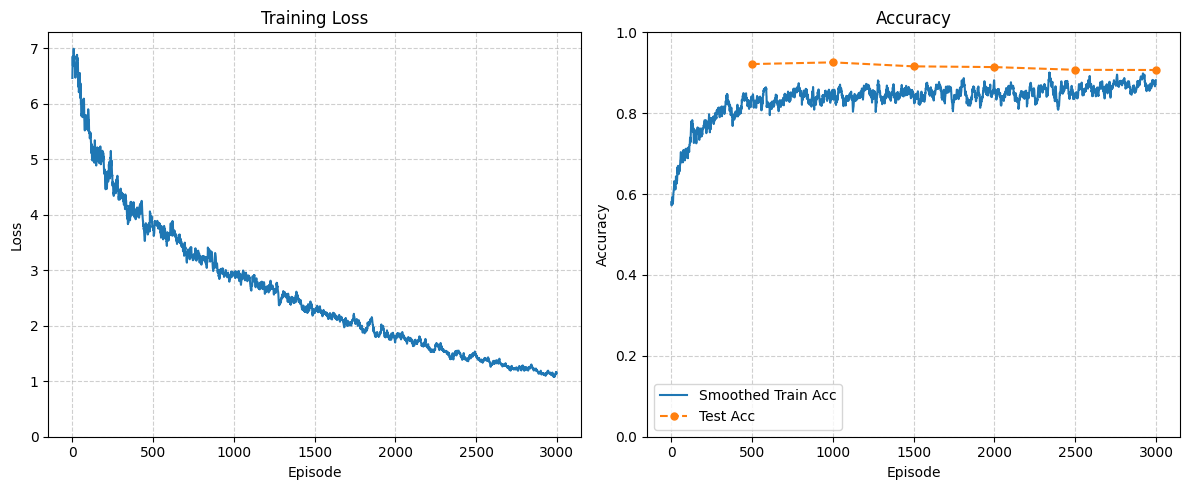


5. Visualizing Explanation on Test Episodes...

--- Visualizing Top-3 Explanations for 5 Test Episodes ---

--- Explanation Example 1/5 ---
Explaining Query Image Index: 33
Predicted Label (local 0-4): 2
True Label (local 0-4): 2
Correct Prediction: Yes
Generated Top-3 patch explanations for 5 relevant support image(s).


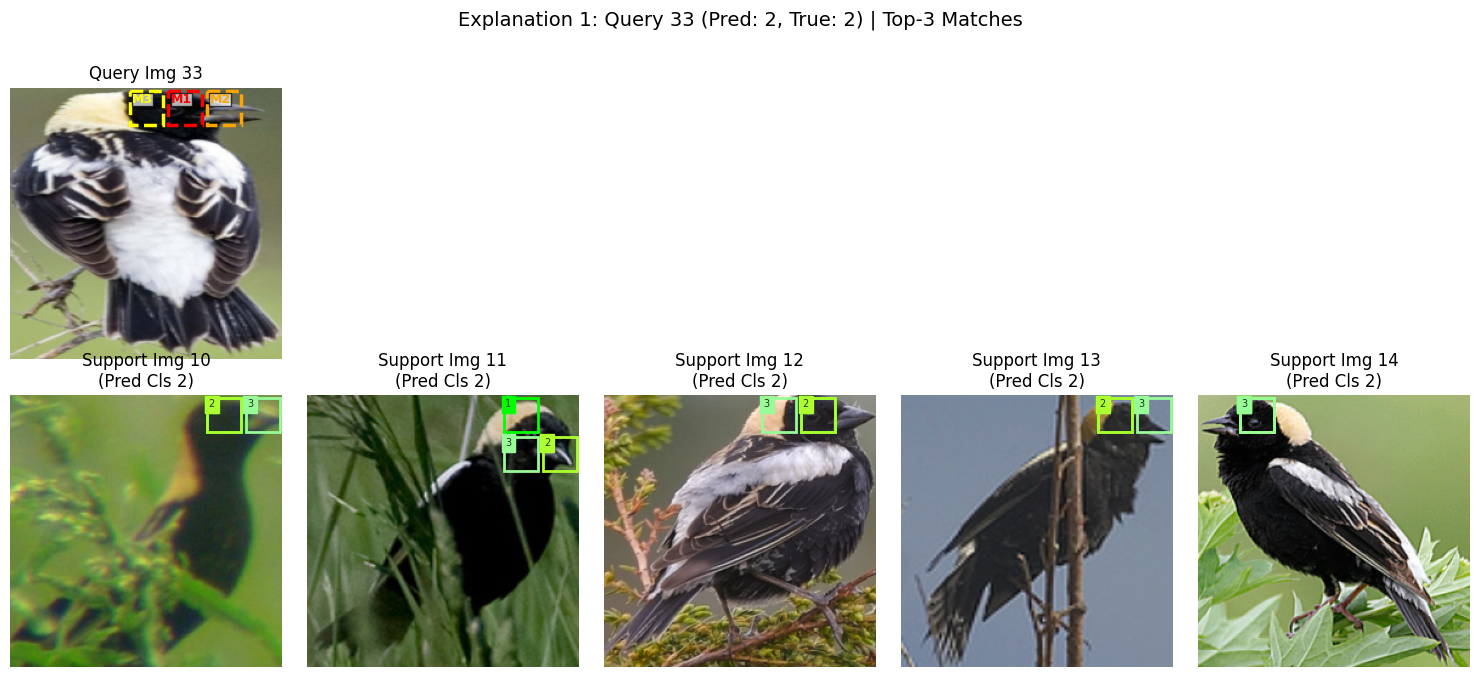


--- Explanation Example 2/5 ---
Explaining Query Image Index: 30
Predicted Label (local 0-4): 0
True Label (local 0-4): 0
Correct Prediction: Yes
Generated Top-3 patch explanations for 5 relevant support image(s).


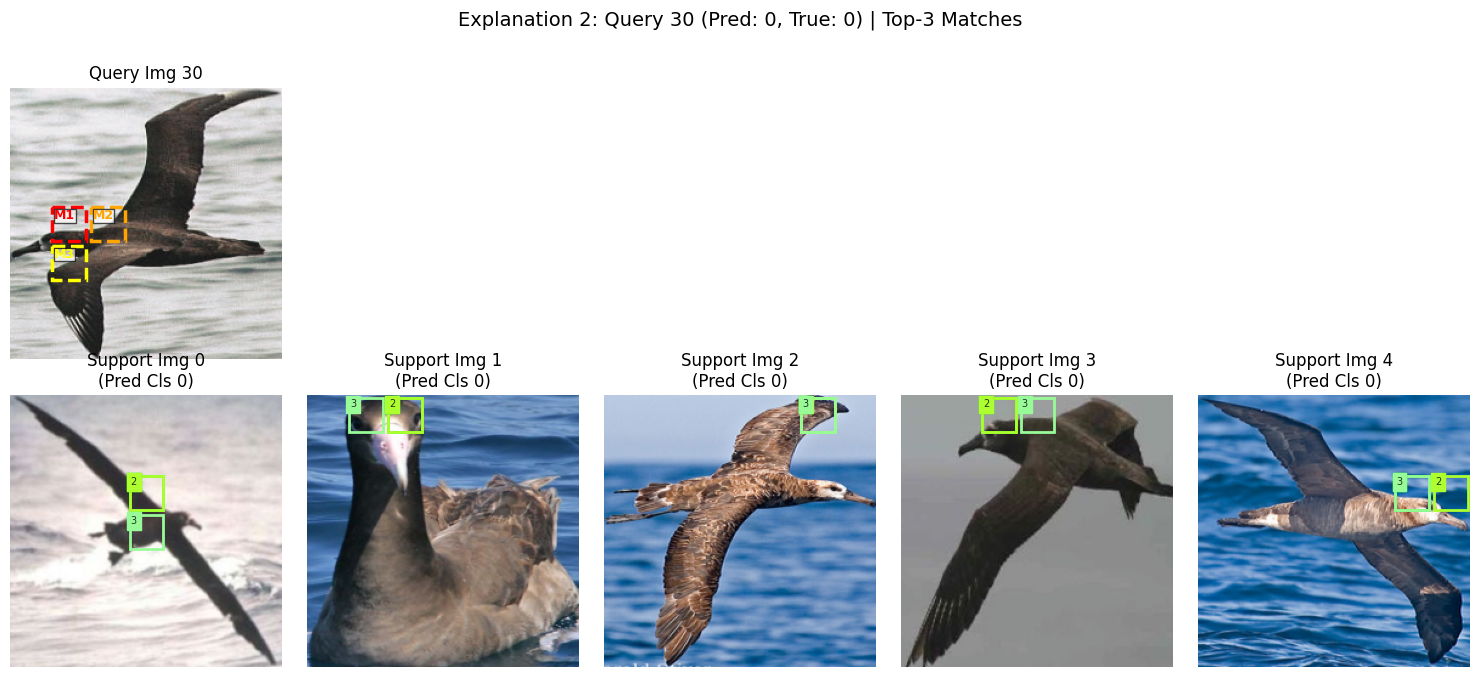


--- Explanation Example 3/5 ---
Explaining Query Image Index: 38
Predicted Label (local 0-4): 4
True Label (local 0-4): 3
Correct Prediction: No
Generated Top-3 patch explanations for 5 relevant support image(s).


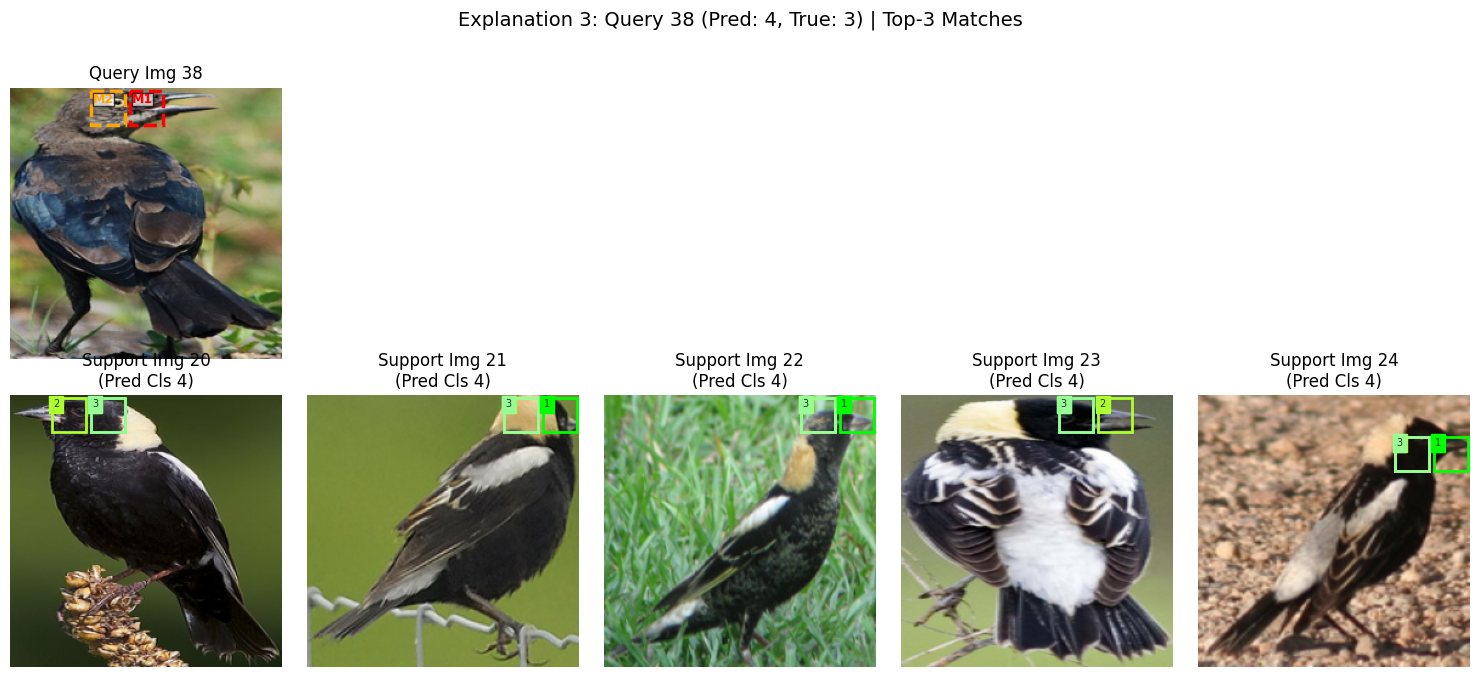


--- Explanation Example 4/5 ---
Explaining Query Image Index: 10
Predicted Label (local 0-4): 4
True Label (local 0-4): 4
Correct Prediction: Yes
Generated Top-3 patch explanations for 5 relevant support image(s).


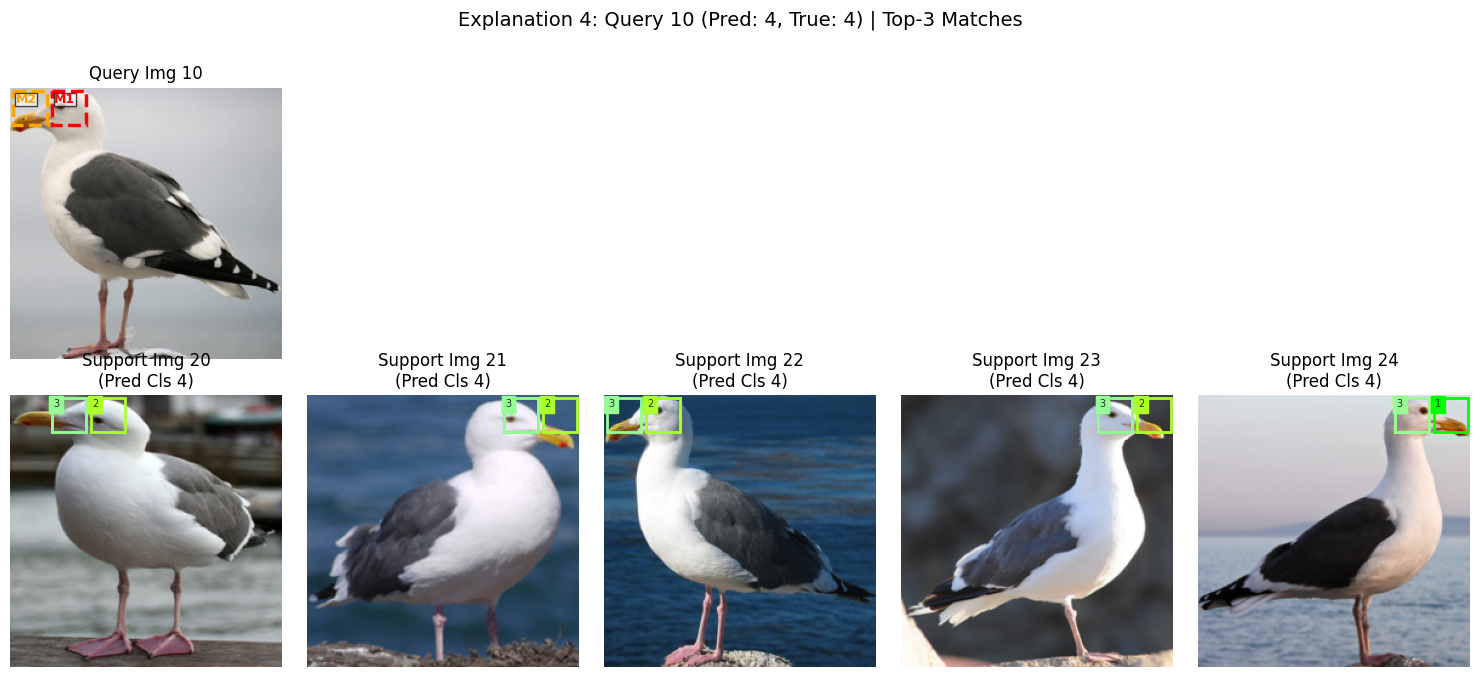


--- Explanation Example 5/5 ---
Explaining Query Image Index: 42
Predicted Label (local 0-4): 0
True Label (local 0-4): 0
Correct Prediction: Yes
Generated Top-3 patch explanations for 5 relevant support image(s).


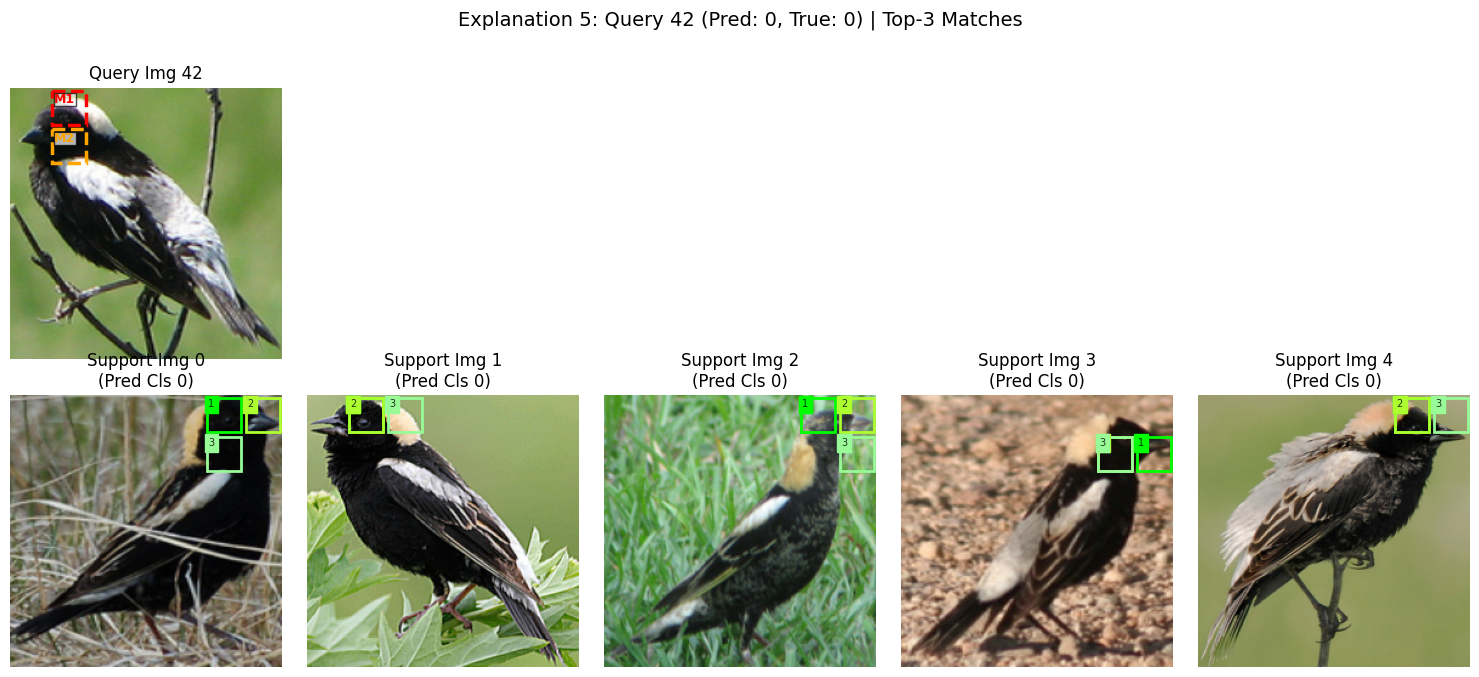

In [27]:
# -------------------------------------
# --- Main Execution ---
# -------------------------------------
if __name__ == "__main__":

    SPLIT_FILE = "cub_meta_split.json" # Define the filename
    FORCE_RESPLIT = True # Set to True if you want to ignore the file and make a new split

    print("1. Preparing CUB Data Splits...")
    meta_train_data, meta_test_data, n_train_classes, n_test_classes = prepare_cub_data_splits(DATA_DIR)

    if meta_train_data and meta_test_data:
        print("\n2. Creating Episode Samplers...")
        train_sampler = EpisodeSampler(meta_train_data, N_WAY, K_SHOT, N_QUERY)
        test_sampler = EpisodeSampler(meta_test_data, N_WAY, K_SHOT, N_QUERY)

        # Sample and print shapes to verify
        s_img, s_lbl, q_img, q_lbl = train_sampler.sample()
        print("Sampled Train Episode shapes:")
        print(f"  Support: {s_img.shape}, {s_lbl.shape} | Query: {q_img.shape}, {q_lbl.shape}")

        print("\n3. Initializing Model (Improved ResNet18)...")
        encoder = ResNetEncoderWithDropout(
            embedding_dim=EMBEDDING_DIM,
            pretrained=PRETRAINED,
            freeze_until=FREEZE_UNTIL_LAYER,
            dropout_rate=0.5 # Default, can be tuned
        ).to(DEVICE)

        model = ExplainablePrototypicalNet(encoder).to(DEVICE)

        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Model Parameters: Total={total_params}, Trainable={trainable_params} (after freezing)")

        print("\n4. Starting Training...")
        # Pass new training hyperparameters
        trained_model = main_training_loop(model, train_sampler, test_sampler,
                                           n_train_episodes=N_TRAIN_EPISODES,
                                           n_test_episodes=N_TEST_EPISODES,
                                           lr_backbone=LR_BACKBONE,
                                           lr_head=LR_HEAD,
                                           wd=WEIGHT_DECAY,
                                           label_smoothing=LABEL_SMOOTHING,
                                           grad_clip_norm=GRADIENT_CLIP_NORM)

        print("\n5. Visualizing Explanation on Test Episodes...")
        visualize_explanation(trained_model, test_sampler, num_explanations=5)

    else:
        print("\n--- ERROR: Failed to prepare data. Check paths and data integrity. Exiting. ---")